## Final project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import glob
import os
from pathlib import Path
import nltk
# nltk.download('wordnet')

In [2]:
repo = Path(os.getcwd())
data_path = repo / '..' / 'data'

In [3]:
df = pd.read_csv(data_path / '02_clean' / 'train.csv')

In [4]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    text = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    text = ' '.join(text)
    return text

In [5]:
df['tweet'] = df['tweet'].apply(lemmatize_text)

In [6]:
kw = pd.get_dummies(df['keyword'], prefix = 'kw')
df = pd.concat([df,kw], axis=1)

In [7]:
from sklearn.model_selection import train_test_split

X = df
y = df["target"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [8]:
X_train_ef = X_train[['uprchar_pct', 'lwrchar_pct', 'lwrcase_pct',
                          'upprcase_pct', 'titlecase_pct']]
X_train_kw = X_train[list(kw.columns)]
X_train = X_train['tweet']

In [9]:
X_test_ef = X_test[['uprchar_pct', 'lwrchar_pct', 'lwrcase_pct',
                          'upprcase_pct', 'titlecase_pct']]
X_test_kw = X_test[list(kw.columns)]
X_test = X_test['tweet']

In [10]:
X = X['tweet']

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
stops = set(stopwords.words('english'))
stops = map(lambda x:x.lower(),stops)
vectorizer = TfidfVectorizer(stop_words=stops)
vectorizer.fit(X)

# extract features
x_train = vectorizer.transform(X_train)
x_test = vectorizer.transform(X_test)

In [12]:
print(x_train.shape, x_test.shape)

(5329, 12866) (2284, 12866)


In [13]:
# x_test_tfidf = pd.DataFrame(x_test.todense(), columns=vectorizer.get_feature_names())
# x_test_ef = X_test_ef.reset_index(drop=True)
# x_test = pd.concat([x_test_tfidf, x_test_ef], axis=1)

x_test = pd.DataFrame(x_test.todense(), columns=vectorizer.get_feature_names())
x_test_kw = X_test_kw.reset_index(drop=True)
x_test_ef = X_test_ef.reset_index(drop=True)
x_test = pd.concat([x_test, x_test_kw, x_test_ef], axis=1)

In [14]:
# x_train_tfidf = pd.DataFrame(x_train.todense(), columns=vectorizer.get_feature_names())
# x_train_ef = X_train_ef.reset_index(drop=True)
# x_train = pd.concat([x_train_tfidf, x_train_ef], axis=1)

x_train = pd.DataFrame(x_train.todense(), columns=vectorizer.get_feature_names())
x_train_kw = X_train_kw.reset_index(drop=True)
x_train_ef = X_train_ef.reset_index(drop=True)
x_train = pd.concat([x_train, x_train_kw, x_train_ef], axis=1)

### PCA

In [15]:
from sklearn.decomposition import PCA

In [16]:
# pca = PCA(n_components=1750)
# pca.fit(x_train)
# x_train = pca.transform(x_train)
# x_test = pca.transform(x_test)

In [17]:
from sklearn.linear_model import LogisticRegression

lg_clf = LogisticRegression(random_state = 0).fit(x_train, y_train)

In [18]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

# precision, recall, f1, and average precision below
y_pred = lg_clf.predict(x_test)

print("Precision:", round(precision_score(y_test, y_pred, average='binary'),2))
print("Recall:", round(recall_score(y_test, y_pred, average='binary'),2))
print("F1:", round(f1_score(y_test, y_pred, average='binary'),2))
print("Average Precision:", round(average_precision_score(y_test, y_pred),2))

Precision: 0.79
Recall: 0.71
F1: 0.75
Average Precision: 0.68


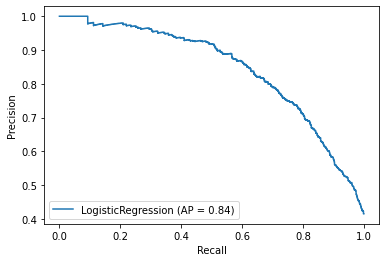

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

# plot precision-recall curve
y_pred_prob = lg_clf.predict_proba(x_test)
precision_recall_curve_values = precision_recall_curve(y_test, y_pred_prob[:,1])
plot_precision_recall_curve(estimator=lg_clf, X=x_test, y=y_test)

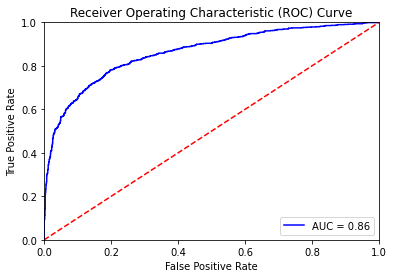

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# plot ROC
lg_fpr, lg_tpr, lg_threshold = roc_curve(y_test, y_pred_prob[:,1])
lg_roc_auc = auc(lg_fpr, lg_tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(lg_fpr, lg_tpr, 'b', label = 'AUC = %0.2f' % lg_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Bayes Classifier

In [21]:
from sklearn.naive_bayes import MultinomialNB

by_clf = MultinomialNB(alpha=1).fit(x_train, y_train)
y_pred = by_clf.predict(x_test)

In [22]:
# print("Precision:", round(precision_score(y_test, y_pred, average='binary'),2))
# print("Recall:", round(recall_score(y_test, y_pred, average='binary'),2))
# print("F1:", round(f1_score(y_test, y_pred, average='binary'),2))
# print("Average Precision:", round(average_precision_score(y_test, y_pred),2))

Precision: 0.78
Recall: 0.68
F1: 0.73
Average Precision: 0.66


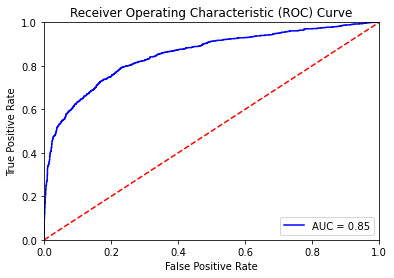

In [23]:
y_pred_prob = by_clf.predict_proba(x_test)
precision_recall_curve_values = precision_recall_curve(y_test, y_pred_prob[:,1])

by_fpr, by_tpr, by_threshold = roc_curve(y_test, y_pred_prob[:,1])
by_roc_auc = auc(by_fpr, by_tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(by_fpr, by_tpr, 'b', label = 'AUC = %0.2f' % by_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
dt_clf = DecisionTreeClassifier(random_state=0, max_depth=5).fit(x_train, y_train)

In [26]:
y_pred = dt_clf.predict(x_test)

print("Precision:", round(precision_score(y_test, y_pred, average='binary'),2))
print("Recall:", round(recall_score(y_test, y_pred, average='binary'),2))
print("F1:", round(f1_score(y_test, y_pred, average='binary'),2))
print("Average Precision:", round(average_precision_score(y_test, y_pred),2))

Precision: 0.6
Recall: 0.61
F1: 0.6
Average Precision: 0.53


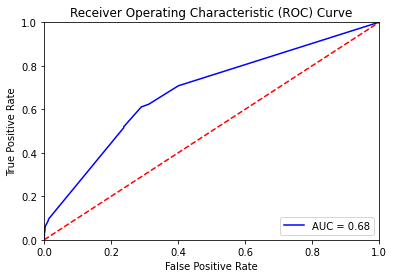

In [27]:
y_pred_prob = dt_clf.predict_proba(x_test)
precision_recall_curve_values = precision_recall_curve(y_test, y_pred_prob[:,1])

dt_fpr, dt_tpr, dt_threshold = roc_curve(y_test, y_pred_prob[:,1])
dt_roc_auc = auc(dt_fpr, dt_tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(dt_fpr, dt_tpr, 'b', label = 'AUC = %0.2f' % dt_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rf_clf = RandomForestClassifier(n_jobs=2, random_state=0).fit(x_train, y_train)

In [43]:
y_pred = rf_clf.predict(x_test)

print("Precision:", round(precision_score(y_test, y_pred, average='binary'),2))
print("Recall:", round(recall_score(y_test, y_pred, average='binary'),2))
print("F1:", round(f1_score(y_test, y_pred, average='binary'),2))
print("Average Precision:", round(average_precision_score(y_test, y_pred),2))

Precision: 0.88
Recall: 0.59
F1: 0.71
Average Precision: 0.69


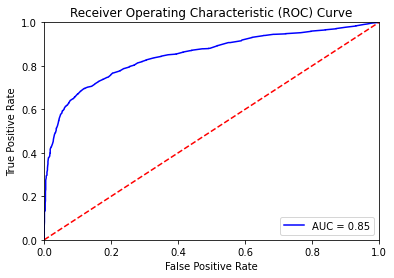

In [44]:
y_pred_prob = rf_clf.predict_proba(x_test)
precision_recall_curve_values = precision_recall_curve(y_test, y_pred_prob[:,1])

rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, y_pred_prob[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(rf_fpr, rf_tpr, 'b', label = 'AUC = %0.2f' % rf_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### MLP Neural Net Classifier

In [32]:
from sklearn.neural_network import MLPClassifier

In [33]:
mlp_clf = MLPClassifier(random_state=0, max_iter=300).fit(x_train, y_train)

In [34]:
y_pred = mlp_clf.predict(x_test)

print("Precision:", round(precision_score(y_test, y_pred, average='binary'),2))
print("Recall:", round(recall_score(y_test, y_pred, average='binary'),2))
print("F1:", round(f1_score(y_test, y_pred, average='binary'),2))
print("Average Precision:", round(average_precision_score(y_test, y_pred),2))

Precision: 0.73
Recall: 0.72
F1: 0.73
Average Precision: 0.65


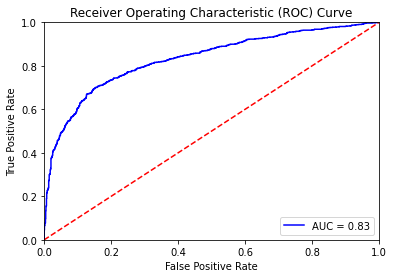

In [35]:
y_pred_prob = mlp_clf.predict_proba(x_test)
precision_recall_curve_values = precision_recall_curve(y_test, y_pred_prob[:,1])

mlp_fpr, mlp_tpr, mlp_threshold = roc_curve(y_test, y_pred_prob[:,1])
mlp_roc_auc = auc(mlp_fpr, mlp_tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(mlp_fpr, mlp_tpr, 'b', label = 'AUC = %0.2f' % mlp_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Results

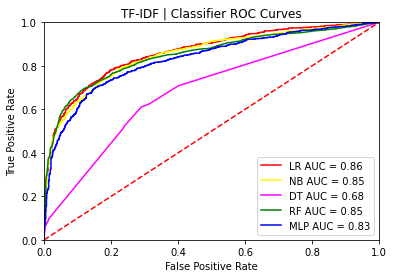

In [36]:
plt.title('TF-IDF | Classifier ROC Curves')
plt.plot(lg_fpr, lg_tpr, 'b', label = 'LR AUC = %0.2f' % lg_roc_auc, color='red')
plt.plot(by_fpr, by_tpr, 'b', label = 'NB AUC = %0.2f' % by_roc_auc, color='yellow')
plt.plot(dt_fpr, dt_tpr, 'b', label = 'DT AUC = %0.2f' % dt_roc_auc, color='magenta')
plt.plot(rf_fpr, rf_tpr, 'b', label = 'RF AUC = %0.2f' % rf_roc_auc, color='green')
plt.plot(mlp_fpr, mlp_tpr, 'b', label = 'MLP AUC = %0.2f' % mlp_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()